<a href="https://colab.research.google.com/github/JoeCWC/UT_spotify_tracks_recommandation_system/blob/main/autoencoding%2Bkmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Recommendation System based on Autoencoder Embedding, KMeans Clustering, and Cosine Similarity

## 專案簡介 (Purpose)

此專案旨在建立一個先進的音樂推薦系統，結合了深度學習（Autoencoder）、無監督學習（KMeans 聚類）與相似度計算（Cosine Similarity），以提供用戶更精準且語意相關的歌曲推薦。系統能夠根據使用者指定的歌曲，推薦風格相似的音樂。

主要特點:

1.  **語意化歌曲定位**: 以歌曲名稱（與可選的 artist）定位目標歌曲。
2.  **Autoencoder Embedding**: 使用 Autoencoder 將高維度的音樂特徵壓縮成低維度的語意 embedding，以捕捉歌曲的深層特徵。
3.  **KMeans 聚類**: 在 Autoencoder embedding 空間中進行 KMeans 聚類，將歌曲分組，確保推薦結果的風格一致性。
4.  **混合式推薦策略**:
    *   **同群優先**: 優先從目標歌曲所屬的同一 cluster 中挑選最相似的歌曲，以保證推薦結果的風格接近。
    *   **跨群補足**: 若同 cluster 歌曲不足以滿足推薦數量，將啟動跨 cluster 備選機制，從其他 cluster 中挑選相似度最高的歌曲補足，並限制每個 cluster 的最大推薦數量 (`max_per_cluster`)，以兼顧多樣性與控制性。
5.  **清晰的輸出格式**: 最終推薦列表包含 `track_name`, `artists`, `cluster` (歌曲所屬聚類), `distance` (與目標歌曲的相似度)。

## 實驗方法與步驟 (Experimental Methods)

### 1. 資料載入與預處理
*   載入 Spotify 音樂數據集。
*   定義音訊特徵 (`audio_features`) 和元數據特徵 (`meta_features`)。
*   移除重複歌曲，確保推薦結果的唯一性。
*   使用 LabelEncoder 將分類特徵 (如 `artists` 和 `track_genre`) 轉換為數值型，以便模型處理。
*   建立包含所有特徵的集合 `all_features`。

### 2. 特徵縮放與主成分分析 (PCA)
*   對所有特徵進行 `StandardScaler` 縮放處理，使數據標準化。
*   使用 PCA 進行數據探索和視覺化，初步了解數據結構。

### 3. Autoencoder 模型建立與訓練
*   建立一個包含 Encoder 和 Decoder 的對稱式 Autoencoder 神經網路模型。
*   Encoder 將高維輸入壓縮成低維的隱藏表示 (embedding)。
*   Decoder 嘗試從隱藏表示重建原始輸入。
*   模型使用 Adam 優化器和 MSE 損失函數進行編譯。
*   應用 `EarlyStopping` 和 `ReduceLROnPlateau` 回調函數來優化訓練過程，防止過擬合並動態調整學習率。

### 4. KMeans 聚類分析
*   利用訓練好的 Encoder 獲取每首歌曲的低維 embedding。
*   在這些 embedding 上應用 KMeans 演算法進行聚類 (k=8)，將歌曲分成若干個群組。
*   將聚類結果 (`cluster_ae_kmeans`) 添加回 DataFrame。

### 5. 聚類結果視覺化與驗證
*   對 Autoencoder embedding 進行 PCA 降維至 2D，並將聚類結果疊加到散佈圖上，視覺化群組分佈。
*   在原始特徵的 PCA 2D 空間中，再次視覺化聚類結果，以評估群組在原始數據空間中的合理性。
*   評估 Silhouette Score, Calinski-Harabasz Score, Davies-Bouldin Index 等指標，衡量聚類品質。

### 6. 自動生成聚類名稱
*   根據每個群組在特定語義特徵（如 energy, danceability）上的中心點，自動生成可讀且唯一的聚類名稱。
*   確保名稱的唯一性，並將命名後的群組 (`cluster_name`) 應用於 DataFrame，用於視覺化。

### 7. 音樂推薦系統建立
*   整合 Autoencoder embedding、KMeans 聚類和 Cosine Similarity，開發核心推薦函式 `recommend_song_ae_cluster`。
*   實作「同群優先、跨群補足」的推薦邏輯。

## 使用步驟 (Usage Steps)

### 1. 運行前置程式碼
請確保您已依照 Colab Notebook 中的順序執行了所有前置的程式碼儲存格，包括數據載入、預處理、Autoencoder 訓練、KMeans 聚類以及 embedding 欄位的建立。

### 2. 使用 `recommend_song_ae_cluster` 函式進行推薦

您可以使用 `recommend_song_ae_cluster` 函式來獲取歌曲推薦。該函式會根據您提供的目標歌曲，利用訓練好的模型推薦相似歌曲。

**函式簽名:**
```python
recommend_song_ae_cluster(
    cluster_col,          # str: 用於推薦的聚類欄位名稱 (e.g., 'cluster_ae_kmeans')
    embedding_cols,       # list: Autoencoder embedding 欄位名稱列表 (e.g., ['emb_0', 'emb_1', ...])
    song_name,            # str: 目標歌曲名稱
    artist=None,          # str, optional: 目標歌曲的藝術家名稱 (可選，提供可提高準確性)
    n_recommendations=5,  # int: 總共需要的推薦數量 (預設為 5)
    max_per_cluster=2     # int: 跨 cluster fallback 時，每個 cluster 最多取幾首 (預設為 2)
)
```

**範例:**

```python
# 假設 embedding_cols 已由前置程式碼生成並儲存到變數中
# 例如: embedding_cols = [f"emb_{i}" for i in range(X_emb.shape[1])]

# 推薦歌曲 'Comedy'，藝術家 'Gen Hoshino'
recommendations = recommend_song_ae_cluster(
    cluster_col="cluster_ae_kmeans",
    embedding_cols=embedding_cols,
    song_name="Comedy",
    artist="Gen Hoshino",
    n_recommendations=5,
    max_per_cluster=2
)

# 顯示推薦結果
if recommendations is not None:
    display(recommendations)
```

**輸出範例:**

```
🎵 Recommendations for 'Comedy' (Artist: Gen Hoshino):

             track_name        artists  cluster  distance
13373       Butterflies      Fiji Blue        7  0.994472
13798          COLORWAY  DESTIN CONRAD        7  0.994398
4515                馬と鹿  Kenshi Yonezu        7  0.993604
13773        Used to Me    Luke Chiang        7  0.993323
13015  Strawberry Skies     Kid Travis        7  0.992104
```

請根據您要推薦的歌曲替換 `song_name` 和 `artist` 參數。

## 實驗方法與步驟

### 1. 資料載入與預處理
*   載入 Spotify 音樂數據集。
*   定義音訊特徵 (audio_features) 和元數據特徵 (meta_features)。
*   移除重複歌曲以避免模型偏差。
*   使用 LabelEncoder 將分類特徵 (如 `artists` 和 `track_genre`) 轉換為數值型，以便模型處理。
*   建立包含所有特徵的集合 `all_features`。

### 2. 特徵縮放與主成分分析 (PCA)
*   對所有特徵進行 `StandardScaler` 縮放處理，使數據標準化。
*   使用 PCA 進行數據探索和視覺化，將數據壓縮到可解釋 95% 變異數的維度，並進一步壓縮到 2D 以進行散佈圖視覺化。

### 3. Autoencoder 模型建立與訓練
*   建立一個包含 Encoder 和 Decoder 的 Autoencoder 神經網路模型。
*   Encoder 將高維輸入壓縮成低維的隱藏表示 (embedding)。
*   Decoder 嘗試從隱藏表示重建原始輸入。
*   模型使用 Adam 優化器和 MSE 損失函數進行編譯。
*   使用 `EarlyStopping` 和 `ReduceLROnPlateau` 回調函數來優化訓練過程，防止過擬合並動態調整學習率。

### 4. KMeans 聚類分析
*   利用訓練好的 Encoder 獲取每首歌曲的低維 embedding。
*   在這些 embedding 上應用 KMeans 演算法進行聚類，將歌曲分成若干個群組 (k=8)。
*   將聚類結果 (`cluster_ae_kmeans`) 添加回 DataFrame。

### 5. 聚類結果視覺化與驗證
*   對 Autoencoder embedding 進行 PCA 降維至 2D，並將聚類結果疊加到散佈圖上，視覺化群組分佈。
*   在原始特徵的 PCA 2D 空間中，再次視覺化聚類結果，以評估群組在原始數據空間中的合理性。

### 6. 自動生成聚類名稱
*   基於每個群組在特定語義特徵 (如 energy, danceability) 上的中心點，自動生成可讀且唯一的聚類名稱。
*   將命名後的群組 (`cluster_name`) 應用於 DataFrame，並更新視覺化圖例。

### 7. 音樂推薦系統建立
*   開發一個基於 Autoencoder embedding、KMeans 聚類和 Cosine Similarity 的音樂推薦系統。
*   該系統能夠根據用戶提供的歌曲名稱和藝術家，推薦相似的歌曲。
*   推薦機制優先從同一群組中選擇最相似的歌曲，並在必要時啟動跨群組的備選機制，確保推薦數量。

In [63]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # 掛載 Google Drive；force_remount 確保重新連線（避免路徑殘留）

Mounted at /content/drive


In [64]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
# 讀取 CSV 文件，將數據加載到 DataFrame 中
df = pd.read_csv("/content/drive/MyDrive/HW_Spotify_Tracks/datasets/dataset.csv")
df.info() # 顯示 DataFrame 的簡要資訊，包括每列的數據類型、非空值數量和記憶體使用情況

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [66]:
# -----------------------------
# 檢查缺失值
# -----------------------------
missing_cols = df.isna().sum()
missing_cols = missing_cols[missing_cols > 0]

for col, missing in missing_cols.items():
    print(f"{col}: {missing} missing")

artists: 1 missing
album_name: 1 missing
track_name: 1 missing


###定義音訊特徵與 metadata 特徵
- audio_features：Spotify 的 9 個連續型音訊特徵
- meta_features：歌曲的歌手、流派、熱門度
### 移除重複歌曲
- 避免同名歌曲造成模型偏差。
### 將類別特徵轉換為數值（Label Encoding）
Autoencoder 與 KMeans 無法處理字串，因此：
- artists → artists_le
- track_genre → genre_le
### 建立最終特徵集合 all_features
包含：
- 9 個 audio features
- popularity（數值）
- artists_le（編碼後的歌手）
- genre_le（編碼後的曲風）


In [67]:
audio_features = [
    'danceability', 'energy', 'valence', 'liveness', 'acousticness',
    'instrumentalness', 'speechiness', 'tempo', 'loudness'
    ]
meta_features = ['artists','popularity','track_genre']

# 建立副本，避免修改原始 df
df = df.copy()

# 補缺失值（避免 NaN 造成 drop_duplicates 行為不一致）
df['track_name'] = df['track_name'].fillna("Unknown Track")
df['artists'] = df['artists'].fillna("Unknown Artist")

# 依 track_name & artists 刪除重複歌曲，保留第一次出現的記錄，避免推薦系統推薦重複歌曲
df = df.drop_duplicates(subset=['track_name','artists'], keep='first').reset_index(drop=True)



In [68]:
'''
同時印出總筆數與 unique 數量 對後續做 Label Encoding、Embedding、Autoencoder 都很有幫助，因為可以快速知道：
- artists 是否為 high-cardinality 特徵
- 是否需要避免 One-Hot
- 是否需要 embedding layer 或 autoencoder
'''
unique_artists = df['artists'].unique().tolist()
print(f"Artists: count={len(unique_artists)}")
unique_genres = df['track_genre'].unique()
print(f"Genres: count={len(unique_genres)}, name={unique_genres}")

Artists: count=31438
Genres: count=113, name=['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'roma

In [69]:
'''
Label Encoding 的使用時機
1. 類別本身有順序（ordinal）
2. 類別數量極大（high cardinality）
'''

# Label encode artists
le_artist = LabelEncoder()
df['artists_le'] = le_artist.fit_transform(df['artists'])

# Label encode track_genre
le_genre = LabelEncoder()
df['genre_le'] = le_genre.fit_transform(df['track_genre'])

In [70]:
# '''
# One-Hot Encoding 的使用時機
# 1. 類別沒有順序（nominal）One-Hot 能讓 Autoencoder 自己學到類別之間的語意距離，而不會被假順序干擾。
# 2. 類別數量不大（< 1000）One-Hot 維度不會太大，Autoencoder 可以有效壓縮。
# 3. 你希望 Autoencoder 學到「類別之間的相似性」

# 同時對 artists 與 genre 做 one-hot encoding 會導致維度過高，記憶體爆炸
# '''
# print("One-Hot encoding 'track_genre'")
# # ===== One-Hot Encoding for genre =====
# ohe = OneHotEncoder(sparse_output=False)

# # 做 One-Hot
# ohe_features = ohe.fit_transform(df[['track_genre']])

# # ===== PCA 壓縮成 embedding（你可調整維度）=====
# pca = PCA(n_components=5, random_state=42)
# emb = pca.fit_transform(ohe_features)

# # ===== 加回 DataFrame =====
# emb_cols = [f"genre_emb_{i}" for i in range(5)]
# df[emb_cols] = emb

# # ===== 產生 genre_le（保留給後續程式碼使用）=====
# # 用 embedding 的第一維當作 genre_le（可排序、有語意）
# df['genre_le'] = df['genre_emb_0']


In [ ]:
'''
相同 Autoencoder 架構下，track_genre 用 Label Encoding 的訓練效果比 One‑Hot Encoding 好很多。
是因為 Autoencoder + One‑Hot 本身就有結構性問題，而 Autoencoder + Label Encoding 反而更符合模型的特性。

1. One‑Hot 維度太高 → Autoencoder 很難重建
假設 genre 有 50 種：
- Label Encoding → 1 維
- One‑Hot → 50 維
Autoencoder 的任務是：
輸入什麼，就要重建什麼

One‑Hot 的特性是：
- 只有一個位置是 1
- 其他全部是 0
- 是一個「極度稀疏」的向量
- 任何小錯誤都會造成 MSE 大幅上升
對 Autoencoder 來說，這是非常困難的重建任務。
✅ 結果：
- train loss 高
- val loss 更高
- 模型很容易過擬合或學不到東西

2. One‑Hot 沒有語意 → Autoencoder 無法學到結構
One‑Hot 的問題：
- 每個 genre 彼此完全獨立
- pop 與 k‑pop 的距離 = pop 與 classical 的距離
- Autoencoder 無法從中學到「相似性」
Autoencoder 是擅長學「連續空間」的模型，而 One‑Hot 是「離散、無語意」的空間。
✅ 結果：
Autoencoder 只能「記住」每個 One‑Hot pattern，而不是「理解」它。

3. Label Encoding 反而提供了「可學習的連續空間」
Label Encoding 雖然不是語意 embedding，但它至少：
- 是連續值（0, 1, 2, 3, …）
- Autoencoder 可以把它當成「數值特徵」來學
- MSE 對連續值更友善
Autoencoder 對連續值的重建能力遠比對 One‑Hot 好。
✅ 結果：
- train loss 明顯下降
- val loss 也更穩定
- 模型更容易收斂

4. One‑Hot 會放大 loss（尤其是 MSE）
假設 One‑Hot 有 50 維：
- 正確答案：只有 1 個位置是 1
- 模型預測：0.8、0.1、0.05、0.02…
MSE 計算方式會讓：
- 那個「應該是 1 的位置」誤差非常大
- 那些「應該是 0 的位置」也會累積大量誤差
所以 One‑Hot 的 MSE loss 本來就會比 Label Encoding 高很多。
5. Autoencoder 的 bottleneck 壓縮會破壞 One‑Hot 結構
One‑Hot 是「離散 + 稀疏 + 高維」
Autoencoder 的 bottleneck 是「連續 + 密集 + 低維」
這兩者本質上不相容。
Label Encoding → bottleneck → 重建
是自然的流程。
One‑Hot → bottleneck → 重建
是非常困難的流程。
'''

In [71]:
# 最終特徵集合
all_features = audio_features + ['popularity', 'artists_le', 'genre_le']

## Scaling + PCA（先看資料結構）
* 這裡的 PCA 先當作「資料探索用」，用來確認音樂特徵是否有可分群的結構

(1) 資料是否呈現出自然的群集？
例如：
- 有明顯的 blob 形狀大致圓或橢圓的資料點群 → KMeans 可能很好用
- 呈現長條狀 / 月牙形 → KMeans 不適合，HDBSCAN / UMAP 會更好
- 完全一團 → 可能需要非線性 embedding（Autoencoder / UMAP）

(2) 是否有離群點？
- 若有明顯孤立點 → clustering 會受影響
- 可能需要先做 outlier removal

(3) 是否有線性可分性？
- 若資料呈現線性方向 → PCA / KMeans 會表現不錯
- 若資料呈現彎曲、非線性 → Autoencoder embedding 會更適合

(4) 是否有「維度塌縮」問題？
如果 2D PCA 看起來像一條線：
- 代表資料高度相關
- clustering 可能會不穩定
- Autoencoder 可能需要更小的 bottleneck


PCA shape: (81344, 10)


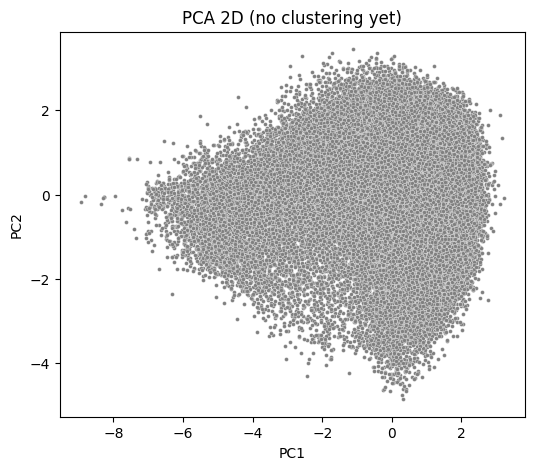

In [72]:
# Scaling
X = df[all_features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 用於檢查/可視化（先壓到能解釋 95% variance）
pca_full = PCA(n_components=0.95, random_state=42)
Xp = pca_full.fit_transform(X_scaled)
print("PCA shape:", Xp.shape)

# 再壓到 2 維做視覺化用
pca_2d = PCA(n_components=2, random_state=42)
Xp_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.title("PCA 2D (no clustering yet)")
sns.scatterplot(
    x=Xp_2d[:, 0], y=Xp_2d[:, 1], s=8, color='gray' #灰色點不會干擾視覺
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Autoencoder 結構與可調參數說明

此段程式碼建立一個對稱式 Autoencoder，用於將高維特徵壓縮成低維 embedding，
再重建回原始空間。可調整的參數會影響模型容量、壓縮程度與重建品質。

可調參數：
- input_dim (int):
    輸入特徵維度，通常為 X_scaled.shape[1]。
    常見範圍：20–500（依資料集特徵數量而定）

- encoding_dim (int):
    Bottleneck（embedding）維度，決定壓縮程度。
    越小 → 壓縮強、資訊密度高，但可能損失細節
    越大 → 保留更多資訊，但 embedding 不夠精煉
    常見範圍：8、16、32、64

- Dense layer units (64 → 32 → encoding_dim → 32 → 64):
    每層神經元數量決定模型容量。
    Encoder 通常逐層縮小，Decoder 逐層放大。
    常見範圍：
        - 大型模型：128 → 64 → 32 → 64 → 128
        - 中型模型（本例）：64 → 32 → 16 → 32 → 64
        - 小型模型：32 → 16 → 8 → 16 → 32

- activation:
    Encoder/Decoder 隱藏層：relu（最常用）
    Bottleneck：linear（避免壓縮空間被非線性扭曲）
    Output layer：linear（重建連續值）

- optimizer:
    Adam（最常用）
    可調 learning_rate：
        常見範圍：1e-4 ～ 1e-3
        本例：0.0005（中等偏小，較穩定）

- loss:
    mse（適用於連續特徵重建）
    若資料經標準化，mse 是最常見選擇。

此 Autoencoder 結構適合用於：
- 建立低維 embedding（用於 KMeans、相似度搜尋）
- 音樂特徵壓縮
- 後續推薦系統的語意向量表示


In [73]:
# ====== 建立 Autoencoder 模型 ======
# input_dim = X_scaled.shape[1]
# encoding_dim = 16

# # Autoencoder 結構
# input_layer = layers.Input(shape=(input_dim,))

# # Encoder
# x = layers.Dense(64, activation='relu')(input_layer)
# x = layers.Dense(32, activation='relu')(x)
# bottleneck = layers.Dense(encoding_dim, activation='linear', name='bottleneck')(x)

# # Decoder
# x = layers.Dense(32, activation='relu')(bottleneck)
# x = layers.Dense(64, activation='relu')(x)
# output_layer = layers.Dense(input_dim, activation='linear')(x)

# autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
# encoder = models.Model(inputs=input_layer, outputs=bottleneck)

# # autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# autoencoder.summary()

In [75]:
# ====== 建立 Autoencoder 模型 加入 L2 正則化 + Dropout ======

input_dim = X_scaled.shape[1]
encoding_dim = 16

# ===== Autoencoder 結構 =====
input_layer = layers.Input(shape=(input_dim,))

# ===== Encoder =====
x = layers.Dense(
    64, activation='relu',
    kernel_regularizer=l2(1e-4)
)(input_layer)
x = layers.Dropout(0.2)(x)

x = layers.Dense(
    32, activation='relu',
    kernel_regularizer=l2(1e-4)
)(x)
x = layers.Dropout(0.2)(x)

bottleneck = layers.Dense(
    encoding_dim, activation='linear',
    name='bottleneck'
)(x)

# ===== Decoder =====
x = layers.Dense(
    32, activation='relu',
    kernel_regularizer=l2(5e-5)
)(bottleneck)
# Decoder dropout 降低
x = layers.Dropout(0.1)(x)

x = layers.Dense(
    64, activation='relu',
    kernel_regularizer=l2(5e-5)
)(x)
# 最後一層通常不加 Dropout

output_layer = layers.Dense(input_dim, activation='linear')(x)

# ===== Models =====
autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
encoder = models.Model(inputs=input_layer, outputs=bottleneck)

autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,876 (26.86 KB)

 Trainable params: 6,876 (26.86 KB)

 Non-trainable params: 0 (0.00 B)

## Autoencoder 訓練設定說明

本段程式碼負責訓練 Autoencoder，使用 X_scaled 作為輸入與輸出，並透過
EarlyStopping 與 ReduceLROnPlateau 提升收斂穩定度。

參數說明：
- X_scaled: 經標準化後的輸入資料（通常 shape = [n_samples, n_features]）

- epochs (int):
    訓練的最大迭代次數。
    常見範圍：50–500（視模型複雜度與 EarlyStopping 而定）
    若使用 EarlyStopping，通常設較大（如 200–1000）讓模型自行決定停止點。

- batch_size (int):
    每次梯度更新所使用的樣本數。
    常見範圍：32、64、128、256
    越大 → 訓練較穩定但需要更多記憶體；越小 → 噪音較大但可能更快收斂。

- shuffle (bool):
    每個 epoch 是否打亂資料。
    建議：True（避免模型記住資料順序）

- validation_split (float):
    用於驗證的資料比例。
    常見範圍：0.05–0.2
    典型值：0.1（10%）

- callbacks:
    訓練監控工具，用於避免過度訓練與提升收斂品質。

    * EarlyStopping:
        - monitor='val_loss': 監控驗證損失
        - patience=10: 若 10 個 epoch 無改善則停止
        - restore_best_weights=True: 回到最佳模型狀態
        常見 patience：5–20

    * ReduceLROnPlateau:
        - factor=0.5: 學習率降低為原本的一半
        - patience=5: 若 5 個 epoch 無改善則降低學習率
        常見 factor：0.1–0.5
        常見 patience：3–10

- verbose (int):
    訓練過程輸出模式。
    0 = 靜默，1 = 每 epoch 顯示，2 = 每 batch 顯示（較少用）
    常見：1

此設定能確保 Autoencoder 在穩定、可控的情況下收斂，並自動避免過度訓練。


In [76]:
# 訓練 Autoencoder
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=200,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ],
    verbose=1
)

Epoch 1/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.7976 - val_loss: 0.4110 - learning_rate: 5.0000e-04
Epoch 2/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3626 - val_loss: 0.2518 - learning_rate: 5.0000e-04
Epoch 3/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2995 - val_loss: 0.2036 - learning_rate: 5.0000e-04
Epoch 4/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2727 - val_loss: 0.1810 - learning_rate: 5.0000e-04
Epoch 5/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2575 - val_loss: 0.1694 - learning_rate: 5.0000e-04
Epoch 6/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2469 - val_loss: 0.1542 - learning_rate: 5.0000e-04
Epoch 7/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2396 - val_loss: 0.1504 - learning_rate: 5.0000e-04
Epoch 8/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2337 - val_loss: 0.1422 - learning_rate: 5.0000e-04
Epoch 9/200
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2290 - val_loss:

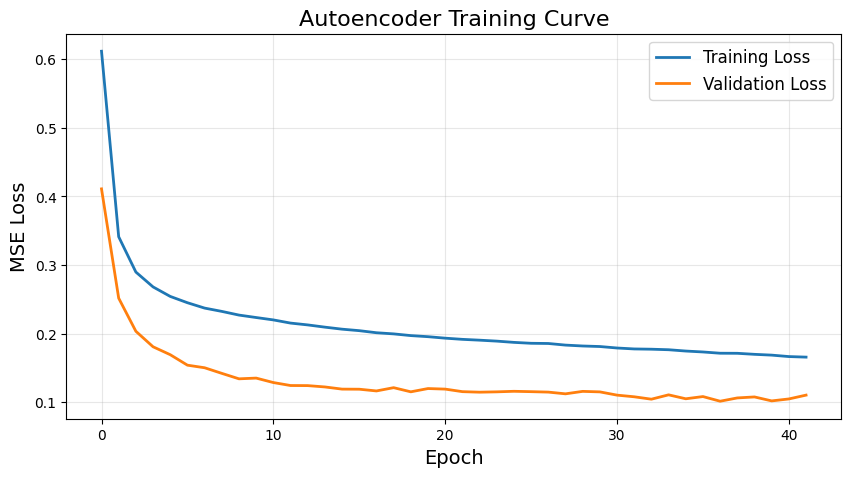

In [77]:
# 視覺化訓練過程
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)

plt.title("Autoencoder Training Curve", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("MSE Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()
plt.close()

##用 PCA 檢查 KMeans 是否合理
* 在 AE embedding 上先做 PCA 壓成 2 維，再畫出來看群集是否分得有結構
##在這張圖上可以檢查：
* 各 cluster 是否有明顯區域感（有邊界、不是完全重疊）
* 是否有某些 cluster 特別零碎或特別小（可能 K 設太大）
* 是否有「一坨大球 + 很多小邊緣」的情況（資料本身結構）


In [78]:
# 取出 Autoencoder embedding
X_emb = encoder.predict(X_scaled)
# logger.info("Embedding shape: %s", X_emb.shape)
print(f"Embedding shape: {X_emb.shape}")

# ====== PCA 2D for visualization ======
pca_emb_2d = PCA(n_components=2, random_state=42)
X_emb_2d = pca_emb_2d.fit_transform(X_emb)

2542/2542 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Embedding shape: (81344, 16)


## 做KMeans 分群

## Clustering 評估指標說明（Silhouette / Calinski–Harabasz / Davies–Bouldin）

三者從不同角度衡量群集的緊密度與分離度。

指標與好壞區間：

1. Silhouette Score（輪廓係數）
   - 範圍：-1 ~ 1，越高越好
   - ＞ 0.50：分群效果很好（群之間分離清楚）
   - 0.25–0.50：中等，可接受
   - 0–0.25：弱，群界線模糊
   - ＜ 0：分群錯誤（樣本被分到錯誤群）

2. Calinski–Harabasz Score（CH 指標）
   - 無固定上限，越高越好
   - 衡量群間距離 / 群內緊密度
   - 必須「相對比較不同 k 值」才有意義
   - 越高代表分群越清晰、群內越緊密

3. Davies–Bouldin Index（DBI）
   - 範圍：0 ~ ∞，越低越好
   - ＜ 0.5：非常好
   - 0.5–1.0：良好
   - 1.0–2.0：普通
   - ＞ 2.0：差（群之間重疊嚴重）

此三指標可搭配使用，用於判斷分群品質、選擇最佳 k 值，或比較不同 embedding 方法的效果。


In [79]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# 輸入想比較的 k 值
k_list = [8,10,12]

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


--- k = 8 ---
Silhouette Score: 0.13036522269248962
Calinski-Harabasz Score: 12007.8173828125
Davies-Bouldin Index: 1.6535803654330568


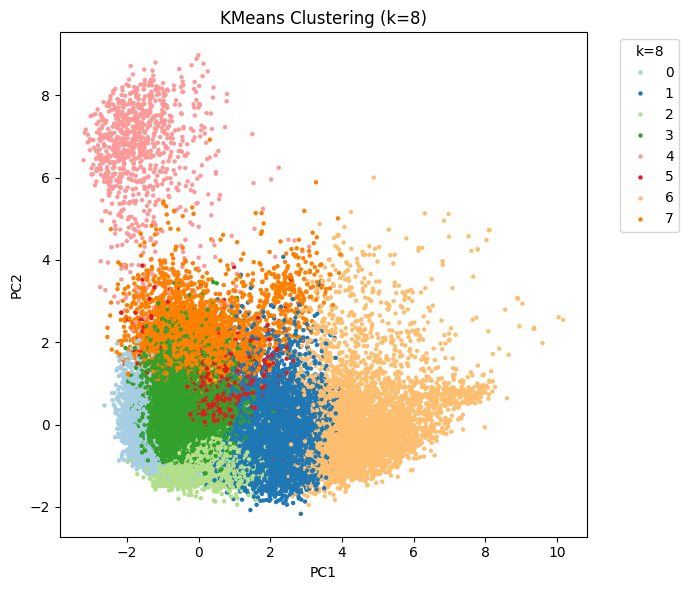


--- k = 10 ---
Silhouette Score: 0.1081836149096489
Calinski-Harabasz Score: 10542.1015625
Davies-Bouldin Index: 1.792936965126043


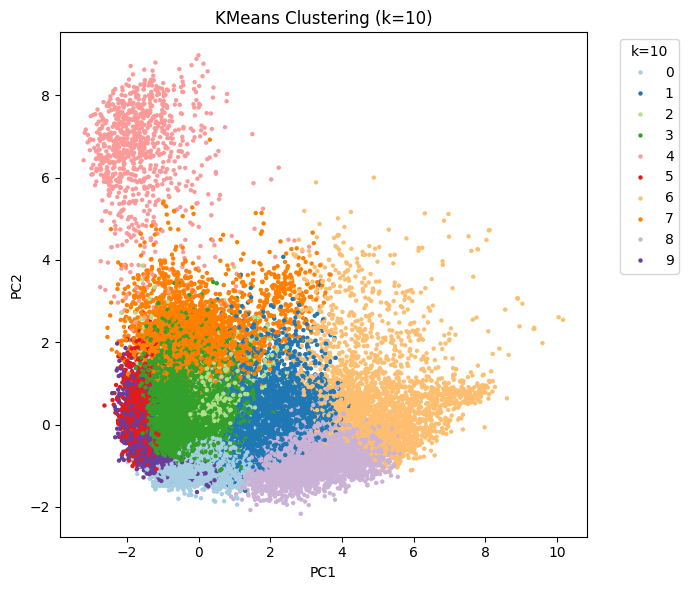


--- k = 12 ---
Silhouette Score: 0.11020897328853607
Calinski-Harabasz Score: 9289.7021484375
Davies-Bouldin Index: 1.835807134530828


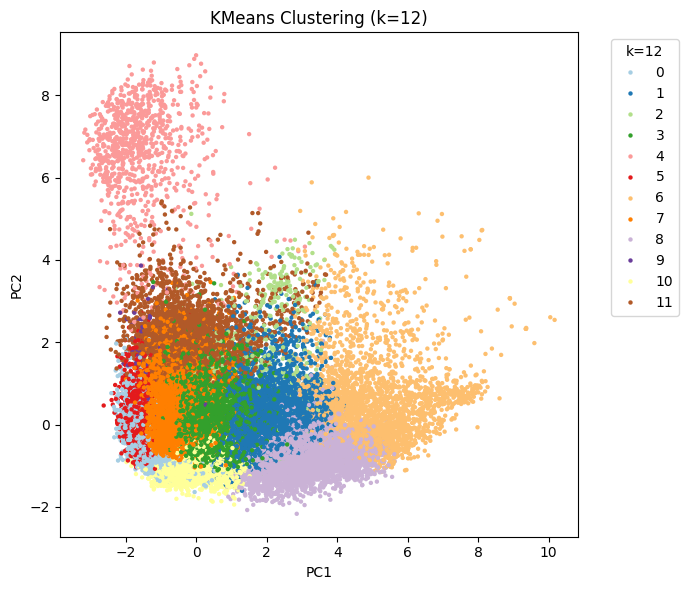

In [80]:
# 每個 k 輸出一張獨立圖片
for k in k_list:

    # ===== KMeans 分群 ======
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_np = kmeans.fit_predict(X_emb)

    # ===== 計算分群品質指標 ======
    sil = silhouette_score(X_emb, labels_np)
    ch = calinski_harabasz_score(X_emb, labels_np)
    dbi = davies_bouldin_score(X_emb, labels_np)

    # logger.info("\n--- k = %d ---", k)
    # logger.info("Silhouette Score: %f", sil)
    # logger.info("Calinski-Harabasz Score: %f", ch)
    # logger.info("Davies-Bouldin Index: %f", dbi)
    print(f"\n--- k = {k} ---")
    print(f"Silhouette Score: {sil}")
    print(f"Calinski-Harabasz Score: {ch}")
    print(f"Davies-Bouldin Index: {dbi}")
    # ===== 每個 k 建立一張新的圖 =====
    plt.figure(figsize=(7, 6))

    sns.scatterplot(
        x=X_emb_2d[:, 0],
        y=X_emb_2d[:, 1],
        hue=labels_np,
        palette="Paired",
        s=10,
        linewidth=0
    )

    plt.title(f"KMeans Clustering (k={k})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    # 顯示 legend
    plt.legend(title=f"k={k}", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    # ===== 輸出獨立圖片 =====
    # plt.savefig(f"{output_dir}/kmeans_clustering_k{k}.png",
    #             dpi=300, bbox_inches='tight')

    plt.close()

In [81]:
# 輸出每個 k 的 KMeans labels
for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_np = kmeans.fit_predict(X_emb)

    # 建立欄位名稱，例如 cluster_ae_kmeans_k8
    col_name = f"cluster_ae_kmeans_k{k}"
    df[col_name] = labels_np

    print(f"已套用 k = {k} 的分群結果，欄位名稱：{col_name}")

已套用 k = 8 的分群結果，欄位名稱：cluster_ae_kmeans_k8
已套用 k = 10 的分群結果，欄位名稱：cluster_ae_kmeans_k10
已套用 k = 12 的分群結果，欄位名稱：cluster_ae_kmeans_k12


## 對原始特徵做 PCA + 上色（看 cluster 映射回原空間）
* 在原始特徵 / 原始 PCA 空間下，AE+KMeans 的 cluster 長什麼樣？是否也合理?
* 是否有某些 cluster 其實在原始空間就已經分得很開
* 是否有 cluster 只是 AE 在 latent space 人工拉開，但原始空間差異不明顯（有時是 good，有時是 overfitting）


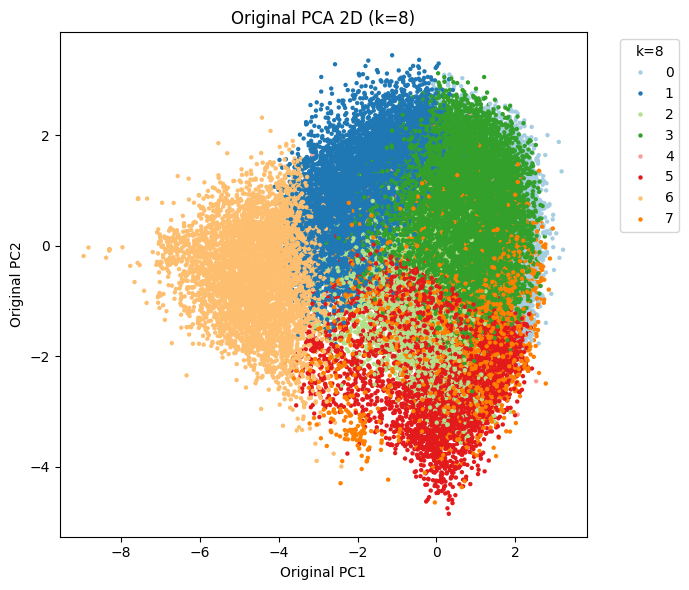

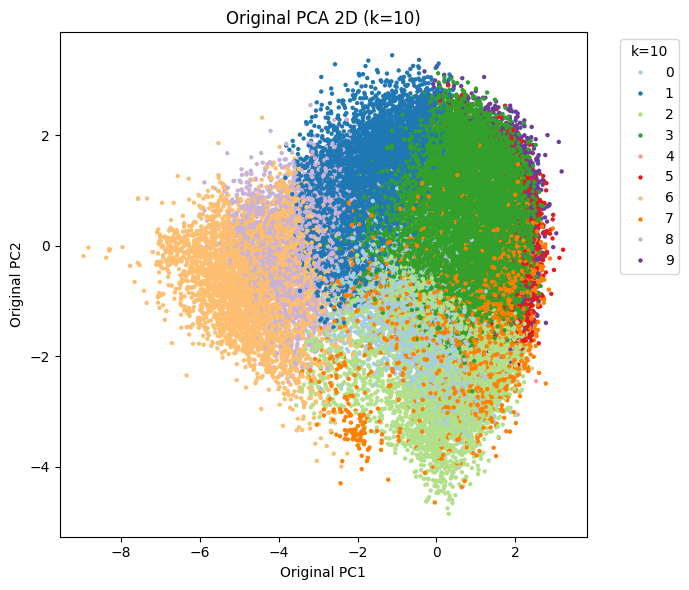

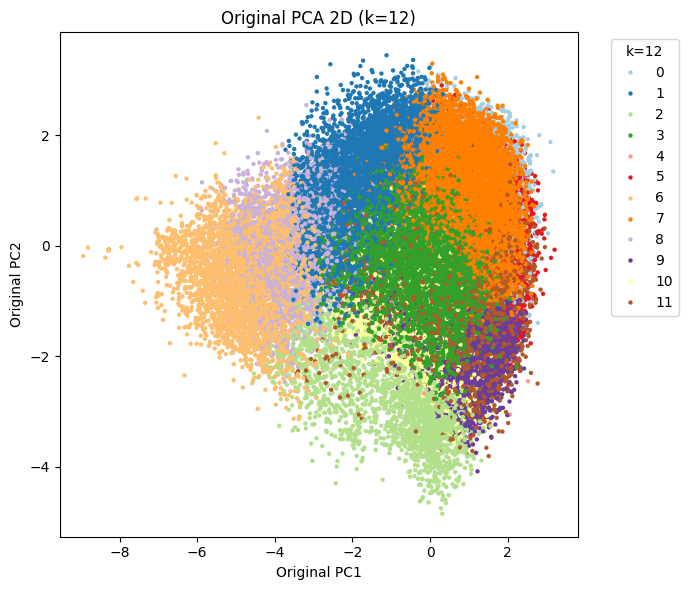

In [82]:
# 每個 k 建立一張新的圖
for k in k_list:
    cluster_col = f"cluster_ae_kmeans_k{k}"   # 對應欄位名稱
    plt.figure(figsize=(7, 6))

    sns.scatterplot(
        x=Xp_2d[:, 0],
        y=Xp_2d[:, 1],
        hue=df[cluster_col],
        palette="Paired",
        s=10,
        linewidth=0
    )

    plt.title(f"Original PCA 2D (k={k})")
    plt.xlabel("Original PC1")
    plt.ylabel("Original PC2")

    # 顯示 legend（如果你想關掉可改成空 legend）
    plt.legend(title=f"k={k}", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    # 每個 k 輸出一張獨立圖片
    # plt.savefig(f"{output_dir}/original_pca_2d_k{k}.png",
    #             dpi=300, bbox_inches='tight')

    plt.close()

## 根據每個 cluster 的特徵分佈，自動產生可讀且唯一的叢集名稱。

1. 以指定的 semantic features 計算各 cluster 的中心點（mean vector）
2. 使用 33% 與 66% quantile 將每個特徵分成 Low / Mid / High 三段
3. 為每個 cluster 產生語意化描述（例如：High Energy / Low Acousticness）
4. 若所有特徵皆落在中段，則命名為 "Balanced"
5. 自動避免名稱重複，必要時附加 cluster 編號以確保唯一性

回傳：
- df：新增欄位 `cluster_name` 的 DataFrame
- cluster_names：cluster_id → cluster_name 的字典


In [83]:
"""
自動命名每個 cluster，保證名稱唯一且可讀
"""
def auto_name_clusters_by_k(df, cluster_col='cluster_ae_kmeans', semantic_features=None,name_col="cluster_name"):
    if semantic_features is None:
        semantic_features = [
            'energy', 'danceability', 'valence', 'acousticness',
            'instrumentalness', 'tempo', 'loudness',
            'speechiness', 'liveness'
        ]

    # 計算每個 cluster 的中心點
    centroids = df.groupby(cluster_col)[semantic_features].mean()

    # 建立 quantile 區間（每個 feature 會有低、中、高三段）
    quantiles = df[semantic_features].quantile([0.33, 0.66])
    q33 = quantiles.loc[0.33]
    q66 = quantiles.loc[0.66]

    cluster_names = {}
    used_names = set()

    for cluster_id, row in centroids.iterrows():
        descriptors = []

        for feature in semantic_features:
            # 大寫開頭特徵名稱（energy → Energy）
            feat_name = feature.capitalize()

            # 取該特徵的 quantile 切點
            f33 = q33[feature]
            f66 = q66[feature]

            # 低
            if row[feature] < f33:
                descriptors.append(f"Low {feat_name}")
            # 高
            elif row[feature] > f66:
                descriptors.append(f"High {feat_name}")
            # 中間則不命名（避免太冗長）
            else:
                continue

        # 若全部都是中間數值 → 給預設描述
        if not descriptors:
            descriptors.append("Balanced")

        # 合併名稱
        name = " / ".join(descriptors)

        # 避免名稱重複
        if name in used_names:
            name = f"{name} (Cluster {cluster_id})"
        used_names.add(name)

        cluster_names[cluster_id] = name

    # df['cluster_name'] = df[cluster_col].map(cluster_names)
    # df[name_col] = cluster_names[df[cluster_col]]
    df[name_col] = df[cluster_col].map(cluster_names)


    return df, cluster_names

/tmp/ipython-input-3571249649.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


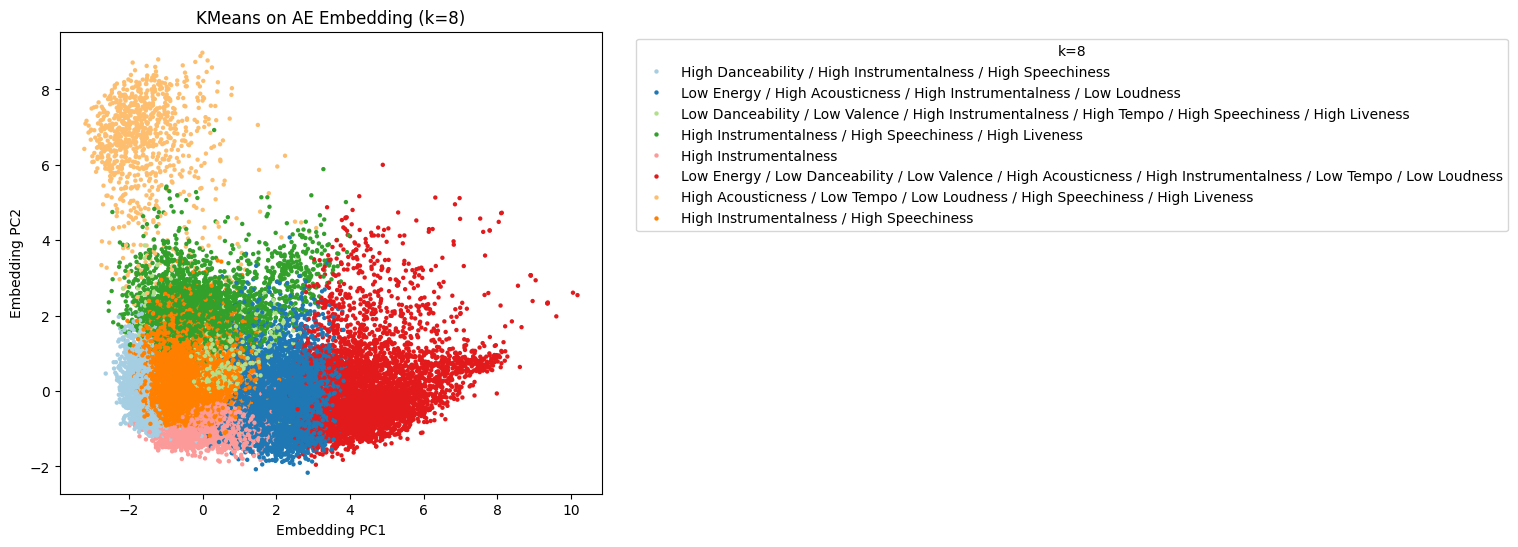

/tmp/ipython-input-3571249649.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


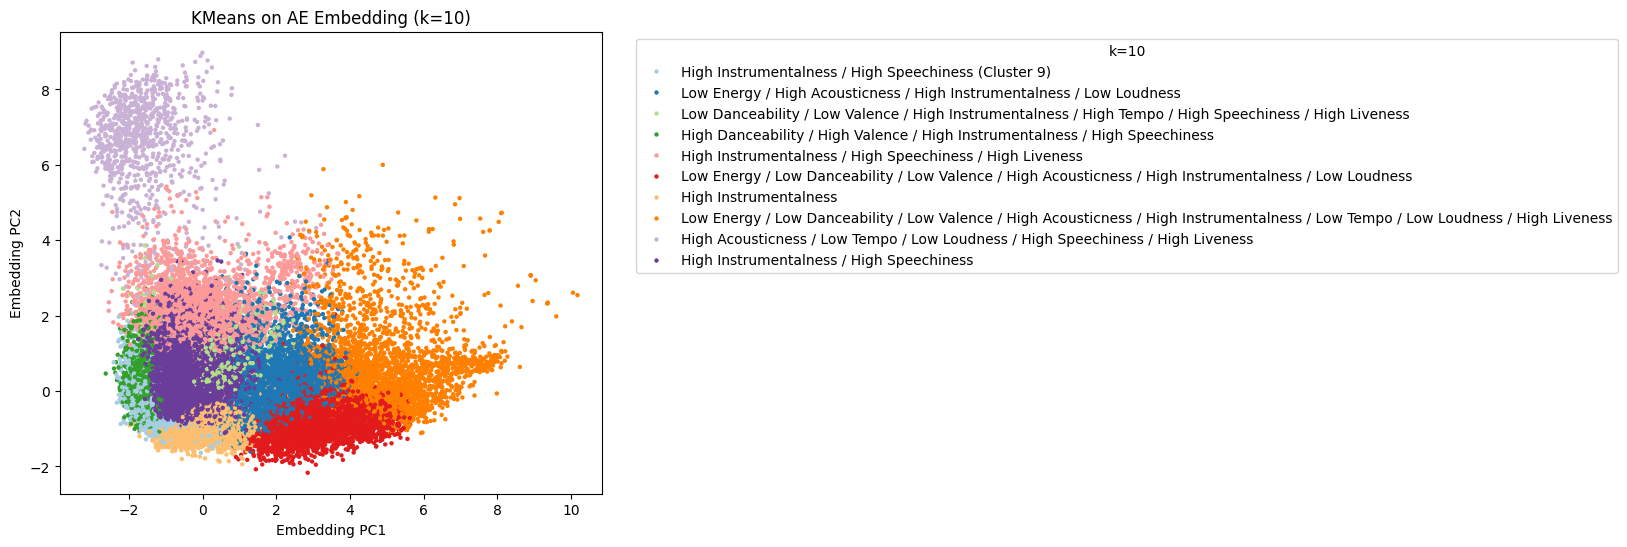

/tmp/ipython-input-3571249649.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


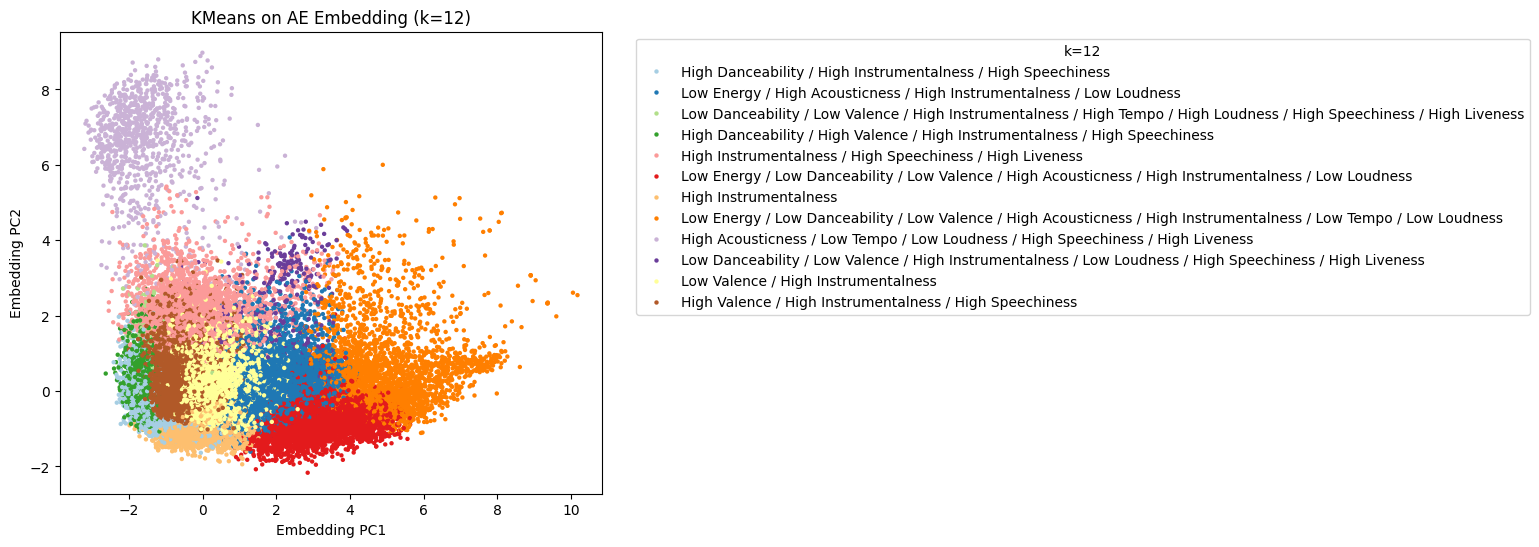

In [84]:
# 視覺化自動命名後的結果
semantic_features = [
            'energy', 'danceability', 'valence', 'acousticness',
            'instrumentalness', 'tempo', 'loudness',
            'speechiness', 'liveness'
        ]

for k in k_list:

    cluster_col = f"cluster_ae_kmeans_k{k}"
    name_col = f"cluster_name_k{k}"

    # 自動命名 cluster
    df, cluster_names = auto_name_clusters_by_k(
        df,
        cluster_col=cluster_col,
        semantic_features=semantic_features,
        name_col=name_col
    )

    # 每個 k 建立一張新的圖
    plt.figure(figsize=(7, 6))

    sns.scatterplot(
        x=X_emb_2d[:, 0],
        y=X_emb_2d[:, 1],
        hue=df[name_col],
        palette="Paired",
        s=10,
        linewidth=0
    )

    plt.title(f"KMeans on AE Embedding (k={k})")
    plt.xlabel("Embedding PC1")
    plt.ylabel("Embedding PC2")

    # 顯示 cluster 名稱
    plt.legend(title=f"k={k}", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    # 每個 k 輸出一張獨立圖片
    # plt.savefig(f"{output_dir}/kmeans_on_ae_embedding_k{k}.png",
    #             dpi=300, bbox_inches='tight')

    plt.close()

## 基於 Autoencoder Embedding、Cluster 與 Cosine Similarity 的混合式音樂推薦系統。

目的：
此函式利用 Autoencoder 壓縮後的 embedding（捕捉歌曲的深層語意特徵），
搭配分群結果（cluster_col）與 cosine similarity，提供更精準且多樣化的歌曲推薦。
推薦邏輯採「同群優先、跨群補足」策略，兼顧相似度與風格多樣性。

優點：
1. **語意更準確的相似度**  
   使用 Autoencoder embedding，而非原始特徵，使相似度更能反映歌曲的整體風格。

2. **同 cluster 優先，提升風格一致性**  
   先從與目標歌曲同群的歌曲中挑選，確保推薦結果風格接近。

3. **跨 cluster fallback，避免推薦不足**  
   若同群歌曲不足，會跨群補足，並限制每個 cluster 的最大推薦數量（max_per_cluster），
   讓推薦結果兼具多樣性與控制性。

4. **避免單一 cluster 過度主導**  
   max_per_cluster 防止某些大群壟斷推薦結果，使推薦更平衡。

5. **可解釋性高**  
   最終輸出包含 track_name、artists、cluster、distance，方便分析推薦來源與相似度。

參數：
- cluster_col (str): 使用的 cluster 欄位名稱（如 'cluster_ae_kmeans'）
- embedding_cols (list): Autoencoder embedding 欄位名稱列表
- song_name (str): 目標歌曲名稱
- artist (str, optional): 目標歌曲的藝術家（可選）
- n_recommendations (int): 需要的推薦數量（預設 5）
- max_per_cluster (int): fallback 時每個 cluster 最多取幾首（預設 2）

回傳：
- recommendations (DataFrame): 最終推薦歌曲列表（含相似度與 cluster）

In [85]:
def recommend_song_ae_cluster(cluster_col,embedding_cols,song_name,artist=None,n_recommendations=5,max_per_cluster=2):
    """
    Autoencoder + Cluster + Cosine Similarity 推薦系統
    - cluster_col: 使用哪個 cluster 欄位（例如 'cluster_ae_kmeans'）
    - embedding_cols: Autoencoder embedding 欄位（list）
    - max_per_cluster: 跨 cluster 時，每個 cluster 最多取幾首
    """

    # 找目標歌曲
    if artist:
        song = df[(df['track_name'].str.lower() == song_name.lower()) &
                  (df['artists'].str.lower() == artist.lower())]
    else:
        song = df[df['track_name'].str.lower() == song_name.lower()]

    if song.empty:
        print(f"Song {song_name} not found in dataset.")
        return None

    song_index = song.index[0]
    song_emb = df.loc[song_index, embedding_cols].values.reshape(1, -1)
    song_cluster = df.loc[song_index, cluster_col]

    # 同 cluster 篩選
    same_cluster = df[(df[cluster_col] == song_cluster) & (df.index != song_index)].copy()

    # 計算 cosine similarity
    same_cluster['distance'] = cosine_similarity(
        same_cluster[embedding_cols].values, song_emb
    ).reshape(-1)

    # 先取同 cluster 的推薦
    recommendations = same_cluster.sort_values('distance', ascending=False).head(n_recommendations)

    # fallback：跨 cluster，但限制每個 cluster 最多 max_per_cluster 首
    if len(recommendations) < n_recommendations:

        remaining_n = n_recommendations - len(recommendations)

        other = df[df.index != song_index].copy()
        other = other[~other.index.isin(recommendations.index)]

        # 計算 cosine similarity
        other['distance'] = cosine_similarity(
            other[embedding_cols].values, song_emb
        ).reshape(-1)

        # 按 cluster 分組，每個 cluster 取 max_per_cluster 首
        fallback_list = []
        for c, group in other.groupby(cluster_col):
            top_c = group.sort_values('distance', ascending=False).head(max_per_cluster)
            fallback_list.append(top_c)

        fallback_df = pd.concat(fallback_list).sort_values('distance', ascending=False)

        # 取剩下需要的數量
        fallback_final = fallback_df.head(remaining_n)

        # 合併
        recommendations = pd.concat([recommendations, fallback_final])

    # 輸出格式統一
    recommendations = recommendations.copy()
    recommendations['cluster'] = recommendations[cluster_col]
    recommendations = recommendations[['track_name', 'artists', 'cluster', 'distance']]

    # logger.info("\n🎵 Recommendations for '%s' (Artist: %s):", song_name, artist if artist else 'Any')
    print("\n🎵 Recommendations for '%s' (Artist: %s):", song_name, artist if artist else 'Any')

    return recommendations

In [86]:
# 自動建立 embedding 欄位名稱
embedding_cols = [f"emb_{i}" for i in range(X_emb.shape[1])]
# 寫入 df
df[embedding_cols] = X_emb
# recommend_song_ae_cluster(cluster_col="cluster_ae_kmeans_k8",embedding_cols=embedding_cols,song_name="Comedy",artist="Gen Hoshino")

for k in k_list:
    cluster_col = f"cluster_ae_kmeans_k{k}"
    # logger.info("\n===== 推薦結果（k = %d）=====", k)
    print(f"\n===== 推薦結果（k = {k}）=====")

    rec = recommend_song_ae_cluster(
        cluster_col=cluster_col,
        embedding_cols=embedding_cols,
        song_name="Comedy",
        artist="Gen Hoshino"
    )

    # logger.info("\n%s", rec)
    print(f"\n{rec}")



===== 推薦結果（k = 8）=====

🎵 Recommendations for '%s' (Artist: %s): Comedy Gen Hoshino

                            track_name                    artists  cluster  \
17478                         Go Crazy     Chris Brown;Young Thug        0   
17459       Bam Bam (feat. Ed Sheeran)  Camila Cabello;Ed Sheeran        0   
2697                     Build a Bitch               Bella Poarch        0   
632    Black Horse And The Cherry Tree                KT Tunstall        0   
13373                      Butterflies                  Fiji Blue        0   

       distance  
17478  0.955696  
17459  0.948044  
2697   0.946692  
632    0.936101  
13373  0.935376  

===== 推薦結果（k = 10）=====

🎵 Recommendations for '%s' (Artist: %s): Comedy Gen Hoshino

                            track_name                    artists  cluster  \
17478                         Go Crazy     Chris Brown;Young Thug        9   
17459       Bam Bam (feat. Ed Sheeran)  Camila Cabello;Ed Sheeran        9   
2697            